<a href="https://www.kaggle.com/code/aditya9790/soc-estimation-lstm?scriptVersionId=128730359" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import time, random
from datetime import datetime, timedelta
import pytz, plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

In [2]:
!tree "/kaggle/input/lg-18650hg2-liion-battery-data/Dataset_Li-ion/LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020"

/kaggle/input/lg-18650hg2-liion-battery-data/Dataset_Li-ion/LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020
├── 0degC
│   ├── 01-12-18_01.14 589_Charge7.mat
│   ├── 01-12-18_04.35 589_Mixed2_0degC_LGHG2.mat
│   ├── 01-12-18_06.36 589_Charge8.mat
│   ├── 01-12-18_14.21 590_Mixed4_0degC_LGHG2.mat
│   ├── 01-12-18_16.16 590_Charge11.mat
│   ├── 01-12-18_19.37 590_Mixed5_0degC_LGHG2.mat
│   ├── 01-12-18_21.26 590_Charge12.mat
│   ├── 02-12-18_00.47 590_Mixed6_0degC_LGHG2.mat
│   ├── 02-12-18_02.32 590_Charge13.mat
│   ├── 02-12-18_05.53 590_Mixed7_0degC_LGHG2.mat
│   ├── 02-12-18_07.36 590_Charge14.mat
│   ├── 02-12-18_10.57 590_Mixed8_0degC_LGHG2.mat
│   ├── 02-12-18_13.05 590_Charge15.mat
│   ├── 02-12-18_16.25 590_PausCycl_0degC_LGHG2.mat
│   ├── 02-12-18_17.10 590_Charge16.mat
│   ├── 11-26-18_22.46 585_HPPC_0degC_LGHG2.mat
│   ├── 11-27-18_20.41 585_C20DisCh_0degC_LGHG2.mat
│   ├── 11-29-18_10.02 585_Dis_0p5C_0degC_LGHG2.mat
│   ├── 11-29-18_15.07 585_Dis_2C_0degC_LGHG2.mat
│   ├─

## data loading

In [3]:
BASE_PATH = "/kaggle/input/lg-18650hg2-liion-battery-data/Dataset_Li-ion"
print(
    os.listdir(
        os.path.join(BASE_PATH, "LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020")
    )
)

['Plot_results.m', 'Readme file - Description of Experimental Tests.txt', '10degC', '0degC', 'n10degC', 'n20degC', '25degC', '40degC', 'Technical Information and Experimental Test Results for LG 18650HG2.pdf']


In [4]:
!pip install nb_black
%load_ext lab_black

  Preparing metadata (setup.py) ... - done
  Created wheel for nb_black: filename=nb_black-1.0.7-py3-none-any.whl size=5297 sha256=1b345846efab8d15b8eb0c15d36a95d92217c7af53fee12f95ad2c06266f8e0b
  Stored in directory: /root/.cache/pip/wheels/1e/b2/88/51c66d23ea5fd0d40ed50997555e15d981d92671376a9a412a
Successfully built nb_black


In [5]:
MAIN_PATH = "/kaggle/input/lg-18650hg2-liion-battery-data/Dataset_Li-ion/LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020"

A brand new 3Ah LG HG2 cell was tested in an 8 cu.ft. thermal chamber with a 75amp, 5 volt Digatron Firing Circuits Universal Battery Tester channel with a voltage and current accuracy of 0.1% of full scale. these data are used in the design process of an SOC estimator using a deep feedforward neural network (FNN) approach. The data also includes a description of data acquisition, data preparation, development of an FNN example script.

A new 3Ah LG HG2 cell was tested in an 8 cu.ft. thermal chamber with a 75amp, 5 volt Digatron Firing Circuits Universal Battery Tester channel with a voltage and current accuracy of 0.1% of full scale.

In [6]:
train1 = os.path.join(MAIN_PATH, "25degC")
l = os.listdir(train1)
l = [i for i in l if i.endswith(".csv")]
l

['549_Dis_2C.csv',
 '551_Charge5.csv',
 '551_Charge6.csv',
 '551_Charge2.csv',
 '551_Charge1.csv',
 '552_Charge12.csv',
 '549_HPPC.csv',
 '552_Charge9.csv',
 '551_LA92.csv',
 '552_Mixed6.csv',
 '552_Charge11.csv',
 '551_HWFET.csv',
 '552_Mixed8.csv',
 '551_Charge3.csv',
 '552_Charge15.csv',
 '551_Mixed1.csv',
 '551_Charge8.csv',
 '551_UDDS.csv',
 '551_Charge4.csv',
 '552_Cap_1C.csv',
 '552_Charge13.csv',
 '552_Mixed7.csv',
 '552_Charge16.csv',
 '552_Mixed4.csv',
 '549_Dis_0p5C.csv',
 '549_C20DisCh.csv',
 '551_Charge7.csv',
 '551_US06.csv',
 '551_Mixed2.csv',
 '549_Charge.csv',
 '552_Charge10.csv',
 '552_Mixed5.csv',
 '552_PausCycl.csv',
 '552_Mixed3.csv',
 '552_Charge14.csv',
 '551_Cap_1C.csv']

In [7]:
train1_csv = os.path.join(train1, "551_LA92.csv")
train1_csv

'/kaggle/input/lg-18650hg2-liion-battery-data/Dataset_Li-ion/LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020/25degC/551_LA92.csv'

In [8]:
df_train1_csv = pd.read_csv(train1_csv, skiprows=30)
df_train1_csv.head()

,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.323,00:00:01.673,1,1.1,LG_HG2_CyclesA,4.19155,-0.05108,23.76583,-0.00000,-0.00000.1,5.00000,Unnamed: 14
0,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.423,00:00:01.773,1,1,LG_HG2_CyclesA,4.19088,-0.08173,23.76583,-0.00000,-0.00001,5.0,NaN
1,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.522,00:00:01.872,1,1,LG_HG2_CyclesA,4.19054,-0.08939,23.76583,-0.00000,-0.00002,5.0,NaN
2,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.622,00:00:01.972,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00003,5.0,NaN
3,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.723,00:00:02.073,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00004,5.0,NaN
4,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.821,00:00:02.171,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00005,5.0,NaN


In [9]:
df_train1_csv.columns = [
    "Time Stamp",
    "Step",
    "Status",
    "Prog Time",
    "Step Time",
    "Cycle",
    "Cycle Level",
    "Procedure",
    "Voltage",
    "Current",
    "Temperature",
    "Capacity",
    "WhAccu",
    "Cnt",
    "Empty",
]

In [10]:
df_train1_csv = df_train1_csv.iloc[:, :-1]  # run only once
df_train1_csv.head(3)

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,Temperature,Capacity,WhAccu,Cnt
0,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.423,00:00:01.773,1,1,LG_HG2_CyclesA,4.19088,-0.08173,23.76583,-0.00000,-0.00001,5.0
1,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.522,00:00:01.872,1,1,LG_HG2_CyclesA,4.19054,-0.08939,23.76583,-0.00000,-0.00002,5.0
2,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.622,00:00:01.972,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00003,5.0


In [11]:
df_train1_csv.describe()

,Step,Cycle,Cycle Level,Voltage,Current,Temperature,Capacity,WhAccu,Cnt
count,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.0
mean,39.119111,3.590197,0.940444,3.702031,-0.926346,24.246026,-1.336233,-4.964102,5.0
std,0.473326,2.064147,0.236663,0.282690,2.406846,0.222317,0.789170,2.811615,0.0
min,39.000000,0.000000,0.000000,2.859260,-12.144700,23.660670,-2.590260,-9.263270,5.0
25%,39.000000,2.000000,1.000000,3.499510,-2.331880,24.081300,-1.999075,-7.365255,5.0
50%,39.000000,4.000000,1.000000,3.716890,-0.155800,24.186460,-1.303810,-4.958720,5.0
75%,39.000000,5.000000,1.000000,3.946430,0.000000,24.396780,-0.663455,-2.591270,5.0
max,41.000000,7.000000,1.000000,4.208720,5.999610,25.027730,-0.000000,-0.000010,5.0


In [12]:
df_train1_csv = df_train1_csv[
    (df_train1_csv["Status"] == "TABLE") | (df_train1_csv["Status"] == "DCH")
]
df_train1_csv.head(3)

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,Temperature,Capacity,WhAccu,Cnt
0,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.423,00:00:01.773,1,1,LG_HG2_CyclesA,4.19088,-0.08173,23.76583,-0.00000,-0.00001,5.0
1,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.522,00:00:01.872,1,1,LG_HG2_CyclesA,4.19054,-0.08939,23.76583,-0.00000,-0.00002,5.0
2,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.622,00:00:01.972,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00003,5.0


In [13]:
max_discharge = abs(min(df_train1_csv["Capacity"]))  # get maximum discharge
df_train1_csv["SoC Capacity"] = max_discharge + df_train1_csv["Capacity"]
df_train1_csv["SoC Percentage"] = df_train1_csv["SoC Capacity"] / max(
    df_train1_csv["SoC Capacity"]
)

In [14]:
df_train1_csv.shape

(94762, 16)

In [15]:
df_train1_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94762 entries, 0 to 94761
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Time Stamp      94762 non-null  object 
 1   Step            94762 non-null  int64  
 2   Status          94762 non-null  object 
 3   Prog Time       94762 non-null  object 
 4   Step Time       94762 non-null  object 
 5   Cycle           94762 non-null  int64  
 6   Cycle Level     94762 non-null  int64  
 7   Procedure       94762 non-null  object 
 8   Voltage         94762 non-null  float64
 9   Current         94762 non-null  float64
 10  Temperature     94762 non-null  float64
 11  Capacity        94762 non-null  float64
 12  WhAccu          94762 non-null  float64
 13  Cnt             94762 non-null  float64
 14  SoC Capacity    94762 non-null  float64
 15  SoC Percentage  94762 non-null  float64
dtypes: float64(8), int64(3), object(5)
memory usage: 12.3+ MB


## EDA

In [16]:
df_train1_csv["Prog Time"]

0        16:50:37.423
1        16:50:37.522
2        16:50:37.622
3        16:50:37.723
4        16:50:37.821
             ...     
94757    19:28:40.577
94758    19:28:40.678
94759    19:28:40.778
94760    19:28:40.878
94761    19:28:40.897
Name: Prog Time, Length: 94762, dtype: object

In [17]:
# time_parts = input_string.split(':')
#         second_parts = time_parts[2].split('.')
#         return timedelta(hours=int(time_parts[0]),
#             minutes=int(time_parts[1]),
#             seconds=int(second_parts[0]),
#             microseconds=int(second_parts[1])).total_seconds()
t1 = df_train1_csv["Prog Time"][0]
time_parts = t1.split(":")
second_part = time_parts[2].split(".")
timedelta(
    hours=int(time_parts[0]),
    minutes=int(time_parts[1]),
    seconds=int(second_part[0]),
    microseconds=int(second_part[1]),
).total_seconds()

60637.000423

In [18]:
df_train1_csv.isnull().sum()

Time Stamp        0
Step              0
Status            0
Prog Time         0
Step Time         0
Cycle             0
Cycle Level       0
Procedure         0
Voltage           0
Current           0
Temperature       0
Capacity          0
WhAccu            0
Cnt               0
SoC Capacity      0
SoC Percentage    0
dtype: int64

SOC vs Voltage

In [19]:
# %%time
# import plotly.graph_objects as go

# fig = go.Figure()

# fig.add_trace(go.Scatter(x = df_train1_csv['Voltage'], y = df_train1_csv['SoC Percentage'],
#                         mode='lines', name='SOC Vs Train'))

# fig.update_layout(title='SOC Vs Train',
#                   xaxis_title='Voltage',
#                   yaxis_title='SOC%')

# fig.show()

In [20]:
# # df_train1_csv
# x_val = df_train1_csv["Voltage"].to_numpy()
# y_val = df_train1_csv["SoC Percentage"].to_numpy()
# plt.figure(figsize=(20, 5))
# sns.lineplot(y=y_val, x=x_val, data=df_train1_csv, color="orange")
# plt.xlabel("Voltage")
# plt.ylabel("SOC %")
# plt.title(
#     "SOC Vs Voltage",
#     fontdict={
#         "fontsize": 20,
#         "fontweight": 3,
#         "verticalalignment": "center",
#         "horizontalalignment": "center",
#     },
# )
# plt.show()

SOC overtime

In [21]:
# %%time
# import plotly.graph_objects as go

# fig = go.Figure()

# fig.add_trace(go.Scatter(x = df_train1_csv['Time Stamp'], y = df_train1_csv['SoC Percentage'],
#                         mode='lines', name='SOC Vs Time'))

# fig.update_layout(title='SOC Vs Time',
#                   xaxis_title='Time',
#                   yaxis_title='SOC%')

# fig.show()

In [22]:
# %%time
# x_val = df_train1_csv['Time Stamp'].to_numpy()
# y_val = df_train1_csv['SoC Percentage'].to_numpy()

# x_ticks_val = np.arange(0, 94762, 94762) # values to display on the x axis

# plt.figure(figsize=(20, 5))
# sns.lineplot(y = y_val, x = x_val, data = df_train1_csv, color='blue')
# plt.xlabel('Time')
# plt.ylabel('SOC %')
# plt.title('SOC Vs Time',
#           fontdict={'fontsize': 20,
#         'fontweight': 3, 'verticalalignment': 'center',
#         'horizontalalignment': 'center'})
# plt.xticks([])
# plt.show()

In [23]:
# plt.figure(figsize=(20, 5))
# a = np.arange(100)
# # 94762/ 7
# sns.lineplot(y = y_val[a], x = x_val[a], data = df_train1_csv.iloc[a], color='blue')
# plt.xticks([])

# for i in a[0::10]:
#     plt.axvline(i, ls='--')

# plt.show()

In [24]:
# %%time
# fig = make_subplots(rows=1, cols=3)

# fig.add_trace(
#     go.Scatter(x=df_train1_csv["Voltage"], y=df_train1_csv["SoC Percentage"], mode="markers",name="Scatter 1"),
#     row=1, col=1
# )

# fig.add_trace(
#     go.Scatter(x=df_train1_csv["Current"],  y=df_train1_csv["SoC Percentage"], mode="markers",name="Scatter 2"),
#     row=1, col=2
# )

# fig.add_trace(
#     go.Scatter(x=df_train1_csv["Temperature"],  y=df_train1_csv["SoC Percentage"], mode="markers", name="Scatter 3",),
#     row=1, col=3
# )

# fig.show()
# # plt.figure(figsize=(20, 5))
# # sns.pairplot(data=df_train1_csv, x_vars = ['Voltage','Current','Temperature', 'Capacity'],
# #             y_vars = ['SoC Percentage'])
# # plt.show()

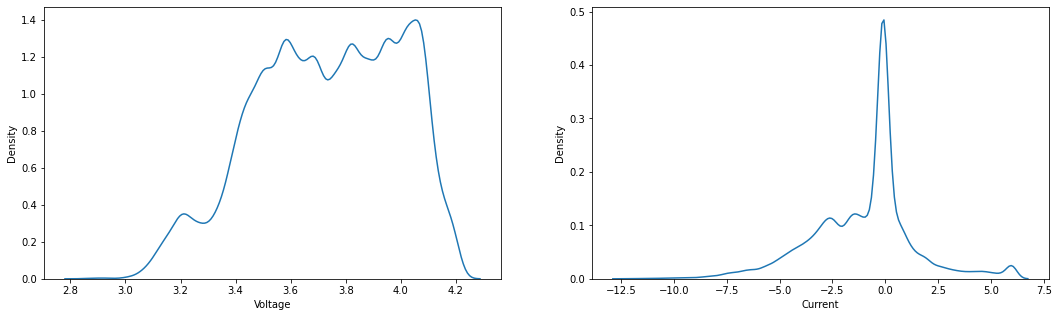

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.kdeplot(data=df_train1_csv, x="Voltage", ax=axes[0])
sns.kdeplot(data=df_train1_csv, x="Current", ax=axes[1])
plt.show()

In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sc = StandardScaler()

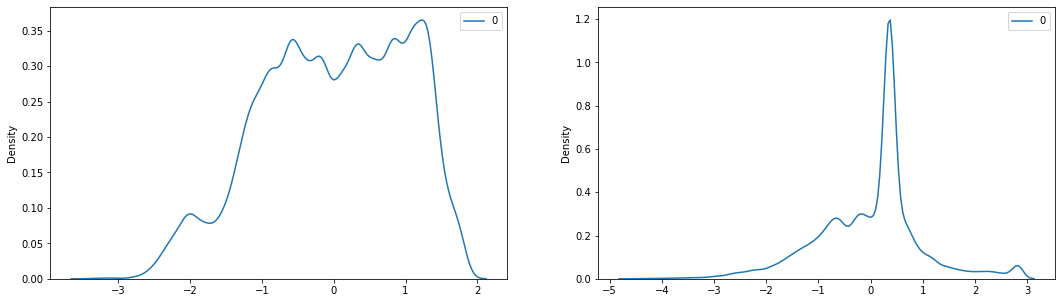

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

x = sc.fit_transform(df_train1_csv["Voltage"].to_numpy().reshape(-1, 1))
x1 = sc.fit_transform(df_train1_csv["Current"].to_numpy().reshape(-1, 1))
sns.kdeplot(data=x, ax=axes[0])
sns.kdeplot(data=x1, ax=axes[1])
plt.show()

Separate X and Y values

In [28]:
df_train1_csv[["Voltage", "Current", "Temperature"]].head()

,Voltage,Current,Temperature
0,4.19088,-0.08173,23.76583
1,4.19054,-0.08939,23.76583
2,4.19037,-0.09195,23.76583
3,4.19037,-0.09195,23.76583
4,4.19037,-0.09195,23.76583


In [29]:
x = df_train1_csv[["Voltage", "Current", "Temperature"]].to_numpy()
y = df_train1_csv[["SoC Percentage"]].to_numpy()

In [30]:
cycles = []
cycles.append((x, y))

In [31]:
# cycles[0] # x, y pair
# print(cycles[0][0])) # gives x
# print(cycles[0][1]) # gives Y
# print(cycles[0][0][0]) # gives voltage, current, temperature values

In [32]:
# np.array(cycles[0][0:0 + steps])#.reshape(1, 300, x_tem_length)

In [33]:
steps = 300
x_length = len(cycles[0][0][0])
y_length = len(cycles[0][1][0])
x = np.empty((0, steps, x_length), float)
y = np.empty((0, steps, y_length), float)
# for cycle in cycles:
#     for i in range(0, len(cycle[0]) - steps, steps):
#         next_x = np.array(cycle[0][i:i + steps]).reshape(1, steps, x_length)
#         next_y = np.array(cycle[1][i:i + steps]).reshape(1, steps, y_length)
#         x = np.concatenate((x, next_x))
#         y = np.concatenate((y, next_y))

In [34]:
# next_x = np.array(cycle)
x_new = np.concatenate((x, np.array(cycles[0][0][0:300]).reshape(1, 300, x_length)))

In [35]:
x_new[:, 0:5]

array([[[ 4.19088, -0.08173, 23.76583],
        [ 4.19054, -0.08939, 23.76583],
        [ 4.19037, -0.09195, 23.76583],
        [ 4.19037, -0.09195, 23.76583],
        [ 4.19037, -0.09195, 23.76583]]])

## Step 1 Data Cleaning

**Function to gat data from the train and test data**<br>
First we will only focus in data that is recorded ranging from 0 to 25 degree celcius.

In [36]:
MAIN_PATH = "/kaggle/input/lg-18650hg2-liion-battery-data/Dataset_Li-ion/LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020/"

In [37]:
def get_discharge_whole_cycle(
    train_files, test_files, output_capacity=False, scale_test=False, output_time=False
):
    """
    This function returns the train and test data for all the cycle
    according to the file paths provided
    and scales according to the user input.
    """
    train = _get_data(train_files, output_capacity, output_time)
    test = _get_data(test_files, output_capacity, output_time)
    train, test = _scale_x(train, test, scale_test=scale_test)
    return (train, test)


# --------------------------------------------------------------------------#


def _get_data(names, output_capacity, output_time=False):
    """
    Returns a tuple of (x, y) values for every file path
    """
    cycles = []
    for name in names:
        #         print(f"Extracting for {name}...")
        cycle = pd.read_csv(MAIN_PATH + name + ".csv", skiprows=30)
        cycle.columns = [
            "Time Stamp",
            "Step",
            "Status",
            "Prog Time",
            "Step Time",
            "Cycle",
            "Cycle Level",
            "Procedure",
            "Voltage",
            "Current",
            "Temperature",
            "Capacity",
            "WhAccu",
            "Cnt",
            "Empty",
        ]
        cycle = cycle[(cycle["Status"] == "TABLE") | (cycle["Status"] == "DCH")]

        max_discharge = abs(min(cycle["Capacity"]))
        cycle["SoC Capacity"] = max_discharge + cycle["Capacity"]
        cycle["SoC Percentage"] = cycle["SoC Capacity"] / max(cycle["SoC Capacity"])
        x = cycle[["Voltage", "Current", "Temperature"]].to_numpy()

        if output_time:
            cycle["Prog Time"] = cycle["Prog Time"].apply(_time_string_to_seconds)
            cycle["Time in Seconds"] = cycle["Prog Time"] - cycle["Prog Time"][0]

        if output_capacity:
            if output_time:
                y = cycle[["SoC Capacity", "Time in Seconds"]].to_numpy()
            else:
                y = cycle[["SoC Capacity"]].to_numpy()
        else:
            if output_time:
                y = cycle[["SoC Percentage", "Time in Seconds"]].to_numpy()
            else:
                y = cycle[["SoC Percentage"]].to_numpy()

        if np.isnan(np.min(x)) or np.isnan(np.min(y)):
            print(f"There is a NaN in cycle {name}, removing row")
            x = x[~np.isnan(x).any(axis=1)]
            y = y[~np.isnan(y).any(axis=1)].reshape(-1, y.shape[1])

        cycles.append((x, y))

    return cycles


# ---------------------------------------------------------------#


def _scale_x(train, test, scale_test=False):
    for index_feature in range(len(train[0][0][0])):
        feature_min = min([min(cycle[0][:, index_feature]) for cycle in train])
        feature_max = max([max(cycle[0][:, index_feature]) for cycle in train])
        for i in range(len(train)):
            train[i][0][:, index_feature] = (
                train[i][0][:, index_feature] - feature_min
            ) / (feature_max - feature_min)
        if scale_test:
            for i in range(len(test)):
                test[i][0][:, index_feature] = (
                    test[i][0][:, index_feature] - feature_min
                ) / (feature_max - feature_min)

    return train, test


# ---------------------------------------------------------------#
print("Done")

Done


**Function to split the dataset into train and test**

In [38]:
def _time_string_to_seconds(input_string):
    time_parts = input_string.split(":")
    second_parts = time_parts[2].split(".")
    return timedelta(
        hours=int(time_parts[0]),
        minutes=int(time_parts[1]),
        seconds=int(second_parts[0]),
        microseconds=int(second_parts[1]),
    ).total_seconds()


# ---------------------------------------------------------------#


def get_discharge_multiple_step(cycles, steps):
    train_x, train_y = _split_to_multiple_step(cycles[0], steps)
    test_x, test_y = _split_to_multiple_step(cycles[1], steps)
    return (train_x, train_y, test_x, test_y)


# ---------------------------------------------------------------#


def _split_to_multiple_step(cycles, steps):
    x_length = len(cycles[0][0][0])
    y_length = len(cycles[0][1][0])
    x = np.empty((0, steps, x_length), float)
    y = np.empty((0, steps, y_length), float)
    for cycle in cycles:
        for i in range(0, len(cycle[0]) - steps, steps):
            next_x = np.array(cycle[0][i : i + steps]).reshape(1, steps, x_length)
            next_y = np.array(cycle[1][i : i + steps]).reshape(1, steps, y_length)
            x = np.concatenate((x, next_x))
            y = np.concatenate((y, next_y))
    return x, y


# ---------------------------------------------------------------#


def keep_only_y_end(y, step, is_stateful=False):
    if is_stateful:
        return y[:, :, ::step]
    else:
        return y[:, ::step]


print("Done")

Done


**Set up training data, test data and other parameters**

In [39]:
train_files = [
    #  '0degC/589_LA92',
    #  '0degC/590_Mixed6',
    #  '0degC/590_Mixed8',
    #  '0degC/589_Mixed1',
    #  '0degC/589_US06',
    #  '10degC/567_Mixed1',
    #  '10degC/571_Mixed8',
    #  '10degC/571_Mixed4',
    #  '10degC/571_Mixed6',
    #  '10degC/567_Mixed2',
    #     '25degC/551_Mixed1',
    #     '25degC/551_Mixed2',
    #     '25degC/551_UDDS',
    #     '25degC/552_Mixed3',
    #     '25degC/552_Mixed8'
    "0degC/589_Mixed1",
    "0degC/589_Mixed2",
    "0degC/590_Mixed4",
    "0degC/590_Mixed5",
    "0degC/590_Mixed6",
    "0degC/590_Mixed8",
    "10degC/567_Mixed1",
    "10degC/567_Mixed2",
    "10degC/571_Mixed4",
    "10degC/571_Mixed5",
    "10degC/571_Mixed6",
    "10degC/571_Mixed8",
    "25degC/551_Mixed1",
    "25degC/551_Mixed2",
    #'25degC/552_Mixed3',
    "25degC/552_Mixed4",
    "25degC/552_Mixed5",
    "25degC/552_Mixed6",
    "25degC/552_Mixed8",
]
test_files = [
    #     "0degC/589_UDDS",
    #     "0degC/589_US06",
    #     "0degC/590_Mixed7",
    #     "10degC/582_LA92",
    #     "10degC/567_US06",
    #     "10degC/571_Mixed7",
    #     "25degC/551_LA92",
    #     "25degC/551_US06",
    #     "25degC/552_Mixed7",
    "0degC/589_LA92",
    "0degC/589_UDDS",
    "0degC/589_US06",
    "0degC/590_Mixed7",
    "10degC/582_LA92",
    "10degC/576_UDDS",
    "10degC/567_US06",
    "10degC/571_Mixed7",
    "25degC/551_LA92",
    "25degC/551_UDDS",
    "25degC/551_US06",
    "25degC/552_Mixed7",
]
steps = 300
# stateful_config = True

In [40]:
%%time
cycles = get_discharge_whole_cycle(train_files, test_files, output_capacity=False, scale_test=True)

There is a NaN in cycle 10degC/582_LA92, removing row
CPU times: user 6.05 s, sys: 975 ms, total: 7.02 s
Wall time: 13.2 s


In [41]:
print(
    f"First element of cycles has {len(cycles[0])} files and they belong to training data.\nSecond element of cycles has {len(cycles[1])} files and they belong to test data."
)

print("Train/Test %d" % len(cycles))
print("x/y :%d" % len(cycles[0][0]))
print("time_steps: %d" % len(cycles[0][0][0]))
print("x features: %d" % len(cycles[0][0][0][0]))

First element of cycles has 18 files and they belong to training data.
Second element of cycles has 12 files and they belong to test data.
Train/Test 2
x/y :2
time_steps: 61310
x features: 3


In [42]:
# len(cycles[0][0][0])  # time_steps: 61310
# max(len(cycle[0]) for cycle in cycles[0])  # 74848
# max(len(cycle[0]) for cycle in cycles[1])  # 142896
# cycles[0][0][0][0]

In [43]:
# def get_stateful_cycle(cycles, pad_num=0, steps=100):
#     max_length = max(
#         max(len(cycle[0]) for cycle in cycles[0]),
#         max(len(cycle[0]) for cycle in cycles[1]),
#     )
#     train_x, train_y = _to_padded_cycle(cycles[0], pad_num, max_length)
#     test_x, test_y = _to_padded_cycle(cycles[1], pad_num, max_length)
#     train_x = _split_cycle(train_x, steps)
#     train_y = _split_cycle(train_y, steps)
#     test_x = _split_cycle(test_x, steps)
#     test_y = _split_cycle(test_y, steps)
#     return (train_x, train_y, test_x, test_y)


# # ---------------------------------------------------------------#


# def _to_padded_cycle(cycles, pad_num, max_length):
#     x_length = len(cycles[0][0][0])
#     y_length = len(cycles[0][1][0])
#     x = np.full((len(cycles), max_length, x_length), pad_num, dtype=float)
#     y = np.full((len(cycles), max_length, y_length), pad_num, dtype=float)
#     for i, cycle in enumerate(cycles):
#         x[i, : cycle[0].shape[0]] = cycle[0]
#         y[i, : cycle[1].shape[0]] = cycle[1]
#     return x, y


# # ---------------------------------------------------------------#


# def _split_cycle(cycles, steps):
#     features = cycles.shape[2]
#     time_steps = cycles.shape[1]
#     new_cycles = np.empty((0, time_steps // steps, steps, features), float)
#     for cycle in cycles:
#         new_cycle = np.empty((0, steps, features), float)
#         for i in range(0, len(cycle) - steps, steps):
#             next_split = np.array(cycle[i : i + steps]).reshape(1, steps, features)
#             new_cycle = np.concatenate((new_cycle, next_split))
#         new_cycles = np.concatenate(
#             (new_cycles, new_cycle.reshape(1, time_steps // steps, steps, features))
#         )
#     return new_cycles

Split the data into train and test

In [44]:
# new
train_x, train_y, test_x, test_y = get_discharge_multiple_step(cycles, steps)

Check the dimentions and visualize the training and test data

In [45]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((4068, 300, 3), (4068, 300, 1), (3218, 300, 3), (3218, 300, 1))

In [46]:
train_x[0][0][:5]  # training x

array([0.96123602, 0.74769365, 0.00387602])

In [47]:
test_x[0][:5]

array([[0.96146405, 0.74758744, 0.00387602],
       [0.96053123, 0.74716384, 0.00387602],
       [0.95971587, 0.74695183, 0.00387602],
       [0.95913545, 0.74695183, 0.00387602],
       [0.95867249, 0.74695183, 0.00775205]])

In [48]:
train_y[:5]  # training y

array([[[1.        ],
        [0.99999574],
        [0.99999574],
        ...,
        [0.99354825],
        [0.99353548],
        [0.99352697]],

       [[0.99351846],
        [0.9935142 ],
        [0.99350995],
        ...,
        [0.99205022],
        [0.99205447],
        [0.99206299]],

       [[0.9920715 ],
        [0.99207575],
        [0.99208426],
        ...,
        [0.98984147],
        [0.98982019],
        [0.98980317]],

       [[0.98978615],
        [0.98976487],
        [0.98974785],
        ...,
        [0.98923715],
        [0.9892329 ],
        [0.9892329 ]],

       [[0.9892329 ],
        [0.9892329 ],
        [0.98922864],
        ...,
        [0.98741143],
        [0.98740717],
        [0.98740717]]])

In [49]:
test_y[:5]  # testing y

array([[[1.        ],
        [1.        ],
        [0.99999574],
        ...,
        [0.99966381],
        [0.99965956],
        [0.99965956]],

       [[0.99965956],
        [0.9996553 ],
        [0.9996553 ],
        ...,
        [0.99837864],
        [0.99837864],
        [0.99837864]],

       [[0.99837864],
        [0.99837864],
        [0.99837864],
        ...,
        [0.99558275],
        [0.99554871],
        [0.99551466]],

       [[0.99547636],
        [0.99543806],
        [0.99539551],
        ...,
        [0.99368053],
        [0.99367627],
        [0.99367627]],

       [[0.99367202],
        [0.99366776],
        [0.99365925],
        ...,
        [0.98988885],
        [0.98988459],
        [0.98988459]]])

In [50]:
train_y = keep_only_y_end(train_y, steps)
test_y = keep_only_y_end(test_y, steps)

In [51]:
# display_x = train_x.reshape(
#     train_x.shape[0] * train_x.shape[1] * train_x.shape[2], train_x.shape[3]
# )
# display_y = train_y.reshape(
#     train_y.shape[0] * train_y.shape[1] * train_y.shape[2], train_y.shape[3]
# )

# display_y

Display the X values

In [52]:
# from plotly.subplots import make_subplots

# fig = go.Figure()

# fig = plotly.subplots.make_subplots(rows=3, cols=1, shared_xaxes=True)

# fig.add_trace(go.Scatter(y=display_x[:,0], mode='lines', name='Voltage'), row=1, col=1)
# fig.update_yaxes(title_text="Voltage", row=1, col=1)

# fig.add_trace(go.Scatter(y=display_x[:,1], mode='lines', name='Current'), row=2, col = 1)
# fig.update_yaxes(title_text="Current", row=2, col=1)

# fig.add_trace(go.Scatter(y=display_x[:,2],mode='lines', name='Temperature'), row = 3, col = 1)
# fig.update_yaxes(title_text="Temperature", row=3, col=1)

# fig.show()

Display the y values

In [53]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(y=display_y[:,0],
#                         mode='lines', name='SoC'))
# fig.update_layout(title='Y Data',
#                     xaxis_title='Step',
#                     yaxis_title='SoC',
#                     width=1000,
#                     height=500)
# fig.show()

## Training the Model

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.layers import LSTM, Embedding, RepeatVector, TimeDistributed, Masking
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

## Iter 2

In [55]:
# def build_model(batch_size):
#     opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
#     model = Sequential()
#     model.add(LSTM(512, activation='tanh',
#                     return_sequences=True,
#                     stateful=True,batch_size=batch_size,
#                     input_shape=(train_x.shape[2], train_x.shape[3])))
#     model.add(LSTM(512, activation='tanh', return_sequences=True, stateful=True))
#     model.add(LSTM(512, activation='tanh', return_sequences=True, stateful=True))
#     model.add(Dense(256, activation='selu'))
#     model.add(Dense(128, activation='selu'))
#     model.add(Dense(1, activation='linear'))
#     model.summary()
#     model.compile(optimizer=opt, loss='huber', metrics=['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
#     return model

In [56]:
# EXPERIMENT = "lstm_soc_lg_stateful"

# itc = pytz.timezone('Asia/Kolkata')

# experiment_name = datetime.now(itc).strftime('%Y:%m:%d %H:%M:%S') + '_' + EXPERIMENT

# print(experiment_name)

# model = build_model(train_x.shape[0])

In [57]:
# %%time

# epochs = 200

# hist = {'loss':[], 'mse':[], 'rmse':[]}
# for epoch in range(epochs):
#     avg_hist = {'loss':[], 'mse':[], 'rmse':[]}
#     shuffled_cycle_index = random.sample(range(train_x.shape[0]), train_x.shape[0]) # select chunks from the 18 chunks created
#     for chunk in range(train_x.shape[1]):
#         batch_x = []
#         batch_y = []
#         for i in shuffled_cycle_index:
#             batch_x.append(train_x[i, chunk, :, :]) # choose a random batch for given chunk and i
#             batch_y.append(train_y[i, chunk, :, :])
#         batch_x = np.array(batch_x)
#         batch_y = np.array(batch_y)
#         results = model.fit(batch_x, batch_y, shuffle=False, verbose=0, batch_size=train_x.shape[0])
#         avg_hist["loss"].append(results.history["loss"]) # append all metrics to the dictionary
#         avg_hist["mse"].append(results.history["mse"])
#         avg_hist["rmse"].append(results.history["rmse"])
#         print('\rChunk {}/{} - loss: {:.4e} - mse: {:.4e} - rmse: {}'.format(chunk, train_x.shape[1], np.mean(avg_hist["loss"]), np.mean(avg_hist["mse"]), np.mean(avg_hist["rmse"])), end="")
#     hist["loss"].append(np.mean(avg_hist["loss"]))
#     hist["mse"].append(np.mean(avg_hist["mse"]))
#     hist["rmse"].append(np.mean(avg_hist["rmse"]))
#     print("\rEpoch {}/{} - loss: {:.4e} - mse: {:.4e} - rmse: {}".format(epoch+1, epochs, hist["loss"][-1], hist["mse"][-1], hist["rmse"][-1]))
#     model.reset_states()

In [58]:
# model.save(data_path + 'results/trained_model/%s.h5' % experiment_name)

# hist_df = pd.DataFrame(history)
# hist_csv_file = data_path + 'results/trained_model/%s_history.csv' % experiment_name
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

## Iter 1 300 steps

In [59]:
itc = pytz.timezone("Asia/Kolkata")

print("UTC in Default Format : ", datetime.now(itc).strftime("%Y:%m:%d-%H:%M:%S"))

UTC in Default Format :  2023:05:08-13:32:28


In [60]:
EXPERIMENT = "lstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test"

experiment_name = datetime.now(itc).strftime("%Y:%m:%d-%H:%M:%S") + "_" + EXPERIMENT
print(f"We are performing : {experiment_name}")

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

model = Sequential()
model.add(
    LSTM(
        256,
        activation="selu",
        return_sequences=True,
        input_shape=(train_x.shape[1], train_x.shape[2]),
    )
)
model.add(LSTM(256, activation="selu", return_sequences=False))
model.add(Dense(256, activation="selu"))
model.add(Dense(128, activation="selu"))
model.add(Dense(64, activation="selu"))
model.add(Dense(1, activation="linear"))
model.summary()

We are performing : 2023:05:08-13:32:28_lstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300, 256)          266240    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 898,

In [61]:
model.compile(
    optimizer=opt,
    loss="huber",
    metrics=["mse", "mae", "mape", tf.keras.metrics.RootMeanSquaredError(name="rmse")],
)

es = EarlyStopping(monitor="val_loss", patience=50)
mc = ModelCheckpoint(
    "/kaggle/working/" + "results/trained_model/%s_best.h5" % experiment_name,
    save_best_only=True,
    monitor="val_loss",
)

In [62]:
%%time
history = model.fit(train_x, train_y, 
                                epochs=150, 
                                batch_size=32, 
                                verbose=1,
                                validation_split=0.2,
                                callbacks = [mc, es]
                               )

Epoch 1/150
102/102 [==============================] - 142s 1s/step - loss: 0.0055 - mse: 0.0111 - mae: 0.0665 - mape: 43.4369 - rmse: 0.1051 - val_loss: 7.0513e-04 - val_mse: 0.0014 - val_mae: 0.0262 - val_mape: 13.3507 - val_rmse: 0.0376
Epoch 2/150
102/102 [==============================] - 135s 1s/step - loss: 9.3596e-04 - mse: 0.0019 - mae: 0.0327 - mape: 20.1548 - rmse: 0.0433 - val_loss: 5.2836e-04 - val_mse: 0.0011 - val_mae: 0.0252 - val_mape: 13.5901 - val_rmse: 0.0325
Epoch 3/150
102/102 [==============================] - 135s 1s/step - loss: 8.8026e-04 - mse: 0.0018 - mae: 0.0325 - mape: 17.5557 - rmse: 0.0420 - val_loss: 4.6547e-04 - val_mse: 9.3094e-04 - val_mae: 0.0220 - val_mape: 11.9098 - val_rmse: 0.0305
Epoch 4/150
102/102 [==============================] - 134s 1s/step - loss: 7.1548e-04 - mse: 0.0014 - mae: 0.0293 - mape: 16.3283 - rmse: 0.0378 - val_loss: 3.8771e-04 - val_mse: 7.7543e-04 - val_mae: 0.0214 - val_mape: 10.1257 - val_rmse: 0.0278
Epoch 5/150
102/102 

In [63]:
model.save("/kaggle/working/" + "results/trained_model/%s.h5" % experiment_name)

history_df = pd.DataFrame(history.history)
history_csv_file = (
    "/kaggle/working/" + "results/trained_model/%s_history.csv" % experiment_name
)
with open(history_csv_file, mode="w") as f:
    history_df.to_csv(f)

## Test the model

In [64]:
model.evaluate(test_x, test_y)

101/101 [==============================] - 9s 86ms/step - loss: 2.8549e-04 - mse: 5.7098e-04 - mae: 0.0186 - mape: 9.4815 - rmse: 0.0239


[0.0002854888734873384,
 0.0005709777469746768,
 0.018592167645692825,
 9.481457710266113,
 0.02389514073729515]

In [65]:
# iter 2
# model.evaluate(test_x, test_y)

## Visualize the result

In [66]:
# from datetime import date
# date = date.today().strftime("%b-%d-%Y")
# date

In [67]:
# os.listdir('/kaggle/working/results/trained_model')

In [68]:
# # file =
# result_df = pd.read_csv('/kaggle/working/results/trained_model/2023:03:01 00:39:37_lstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test_history.csv')
# result_df.head()

In [69]:
# result_df.to_csv('iter3.csv')

### Plotting trainining and Validation loss

In [70]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history["loss"], mode="lines", name="train"))
fig.add_trace(
    go.Scatter(y=history.history["val_loss"], mode="lines", name="validation")
)
fig.update_layout(title="Loss trend", xaxis_title="epoch", yaxis_title="loss")
fig.show()

RMSE Plotting

In [71]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history["rmse"], mode="lines", name="train"))
fig.add_trace(
    go.Scatter(y=history.history["val_rmse"], mode="lines", name="validation")
)
fig.update_layout(title="RMSE trend", xaxis_title="epoch", yaxis_title="rmse")
fig.show()

In [72]:
# # iter 2
# fig = go.Figure()
# fig.add_trace(go.Scatter(y = history.history['loss'], mode='lines', name = 'train'))

# fig.add_trace(go.Scatter(y = history.history['val_loss'], mode='lines', name = 'validation'))

# fig.update_layout(title='Loss trend',
#                   xaxis_title='epoch',
#                   yaxis_title='loss')
# fig.show()

### Predictions on training

In [73]:
train_predictions = model.predict(train_x)

In [74]:
cycle_num = 0
steps_num = 8000
step_index = np.arange(cycle_num * steps_num, (cycle_num + 1) * steps_num)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=step_index,
        y=train_predictions.flatten()[
            cycle_num * steps_num : (cycle_num + 1) * steps_num
        ],
        mode="lines",
        name="SoC predicted",
    )
)
fig.add_trace(
    go.Scatter(
        x=step_index,
        y=train_y.flatten()[cycle_num * steps_num : (cycle_num + 1) * steps_num],
        mode="lines",
        name="SoC actual",
    )
)
fig.update_layout(
    title="Results on training", xaxis_title="Step", yaxis_title="SoC percentage"
)
fig.show()

### Predictions on testing

In [75]:
test_predictions = model.predict(test_x)

In [76]:
# for i in range(len(predictions)):
#     test_predictions[i] = inverse_transform(test_predictions[i], scaling_factors)

In [77]:
cycle_num = 0
steps_num = 8000
step_index = np.arange(cycle_num * steps_num, (cycle_num + 1) * steps_num)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=step_index,
        y=test_predictions.flatten()[
            cycle_num * steps_num : (cycle_num + 1) * steps_num
        ],
        mode="lines",
        name="SoC predicted",
    )
)
fig.add_trace(
    go.Scatter(
        x=step_index,
        y=test_y.flatten()[cycle_num * steps_num : (cycle_num + 1) * steps_num],
        mode="lines",
        name="SoC actual",
    )
)
fig.update_layout(
    title="Results on testing", xaxis_title="Step", yaxis_title="SoC percentage"
)
fig.show()

In [78]:
# test_y.flatten()
# test_predictions

# Test

In [79]:
# /kaggle/working/results/trained_model/2023:04:18 16:38:15_lstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test.h5

# /kaggle/working/results/trained_model/2023:04:21-14:39:56_lstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test.h5

# /kaggle/working/results/trained_model/2023:04:21-14:39:56_lstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test_best.h5

In [80]:
# !rm "/kaggle/working/best_models.csv"

In [81]:
# experiment_name = "2023:04:21-14:39:56_lstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test"

history = pd.read_csv(
    "/kaggle/input/best-model-h5/2021-01-12-23-17-13_lstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test_history.csv"
)

model = keras.models.load_model(
    "/kaggle/input/best-model-h5/2021-01-12-23-17-13_lstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test.h5"
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300, 256)          266240    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 890,369
Trainable params: 890,369
Non-trainable params: 0
_________________________________________________________________


In [82]:
history

,Unnamed: 0,loss,mse,mae,mape,rmse,val_loss,val_mse,val_mae,val_mape,val_rmse
0,0,0.010751,0.021504,0.092660,57.806381,0.146642,0.001062,0.002124,0.035125,20.881390,0.046087
1,1,0.001235,0.002471,0.037531,22.637829,0.049708,0.000748,0.001497,0.030127,20.278002,0.038690
2,2,0.000970,0.001940,0.033608,19.300547,0.044045,0.000788,0.001576,0.032318,24.825243,0.039702
3,3,0.000901,0.001802,0.032795,19.490223,0.042448,0.000536,0.001073,0.026457,18.567413,0.032750
4,4,0.000786,0.001571,0.030548,18.266016,0.039642,0.000496,0.000991,0.025225,19.516239,0.031484
...,...,...,...,...,...,...,...,...,...,...,...
292,292,0.000127,0.000255,0.012314,5.865608,0.015963,0.000198,0.000395,0.016304,14.563918,0.019886
293,293,0.000134,0.000267,0.012503,5.727811,0.016354,0.000082,0.000164,0.009452,5.396430,0.012806
294,294,0.000165,0.000330,0.013974,6.323273,0.018152,0.000566,0.001131,0.031493,19.374268,0.033636
295,295,0.000176,0.000352,0.014641,6.739522,0.018764,0.000191,0.000382,0.016957,10.302731,0.019547


In [83]:
results = model.evaluate(test_x, test_y[:, :, 0])
print(results)

101/101 [==============================] - 10s 92ms/step - loss: 1.9788e-04 - mean_squared_error: 3.9577e-04 - mean_absolute_error: 0.0147 - mean_absolute_percentage_error: 8.7310 - rmse: 0.0199
[0.00019788432109635323, 0.00039576864219270647, 0.014733703806996346, 8.731038093566895, 0.019893934950232506]


## Visualization

In [84]:
# loss
fig = go.Figure()
fig.add_trace(go.Scatter(y=history["loss"], mode="lines", name="train"))
fig.add_trace(go.Scatter(y=history["val_loss"], mode="lines", name="validation"))

fig.update_layout(title="Loss Trend", xaxis_title="epochs", yaxis_title="loss")

In [85]:
# # mae
fig = go.Figure()
fig.add_trace(go.Scatter(y=history["mae"], mode="lines", name="train"))
fig.add_trace(go.Scatter(y=history["val_mae"], mode="lines", name="validation"))

fig.update_layout(title="MAE Trend", xaxis_title="epochs", yaxis_title="MAE")

# Testing

In [86]:
train_predictions = model.predict(train_x)

In [87]:
cycle_num = 0
steps_num = 8000
step_index = np.arange(cycle_num * steps_num, (cycle_num + 1) * steps_num)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=step_index,
        y=train_predictions.flatten()[
            cycle_num * steps_num : (cycle_num + 1) * steps_num
        ],
        mode="lines",
        name="SoC predicted",
    )
)
fig.add_trace(
    go.Scatter(
        x=step_index,
        y=train_y[:, :, 0].flatten()[
            cycle_num * steps_num : (cycle_num + 1) * steps_num
        ],
        mode="lines",
        name="SoC actual",
    )
)
fig.update_layout(
    title="Results on training", xaxis_title="Step", yaxis_title="SoC percentage"
)
fig.show()

In [88]:
def get_test_data(test_names):
    train_names = [
        "0degC/589_Mixed1",
        "0degC/589_Mixed2",
        "0degC/590_Mixed4",
        "0degC/590_Mixed5",
        "0degC/590_Mixed6",
        "0degC/590_Mixed8",
        "10degC/567_Mixed1",
        "10degC/567_Mixed2",
        "10degC/571_Mixed4",
        "10degC/571_Mixed5",
        "10degC/571_Mixed6",
        "10degC/571_Mixed8",
        "25degC/551_Mixed1",
        "25degC/551_Mixed2",
        #'25degC/552_Mixed3',
        "25degC/552_Mixed4",
        "25degC/552_Mixed5",
        "25degC/552_Mixed6",
        "25degC/552_Mixed8",
    ]
    cycles = get_discharge_whole_cycle(
        train_names,
        test_names,
        output_capacity=False,
        scale_test=True,
        output_time=True,
    )
    _, _, test_x, test_y = get_discharge_multiple_step(cycles, 300)
    test_y = keep_only_y_end(test_y, 300)
    return test_x, test_y


def plot_test_performance(test_x, test_y):
    test_predictions = model.predict(test_x)

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=test_y[:, :, 1].flatten(),
            y=test_predictions.flatten(),
            mode="lines",
            name="SoC predicted",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=test_y[:, :, 1].flatten(),
            y=test_y[:, :, 0].flatten(),
            mode="lines",
            name="SoC actual",
        )
    )
    fig.update_layout(
        title="Results on testing", xaxis_title="Time(s)", yaxis_title="SoC percentage"
    )
    fig.show()


def gen_chart(test_name, test_x, test_y):
    test_predictions = model.predict(test_x)

    f = plt.figure(figsize=(10, 5))
    plt.plot(
        test_y[:, :, 1].flatten(),
        test_y[:, :, 0].flatten(),
        label="Actual",
        color="black",
    )
    plt.plot(
        test_y[:, :, 1].flatten(),
        test_predictions.flatten(),
        label="Estimated",
        linestyle="--",
        color="red",
    )
    plt.xlabel("Time(s)")
    plt.ylabel("SOC")
    plt.legend()
    plt.show()


def show_result(cycle, name):
    test_x, test_y = get_test_data([cycle])

    print(model.evaluate(test_x, test_y[:, :, 0]))
    plot_test_performance(test_x, test_y)

    test_x, test_y = get_test_data([cycle])
    gen_chart(name, test_x, test_y)

## 0 deg 

31/31 [==============================] - 3s 93ms/step - loss: 2.5701e-04 - mean_squared_error: 5.1402e-04 - mean_absolute_error: 0.0169 - mean_absolute_percentage_error: 13.0175 - rmse: 0.0227
[0.0002570100186858326, 0.0005140200373716652, 0.016892671585083008, 13.017532348632812, 0.022672010585665703]
8/8 [==============================] - 1s 142ms/step - loss: 1.3673e-04 - mean_squared_error: 2.7346e-04 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 7.0245 - rmse: 0.0165
[0.00013672902423422784, 0.00027345804846845567, 0.012536483816802502, 7.024538040161133, 0.016536567360162735]


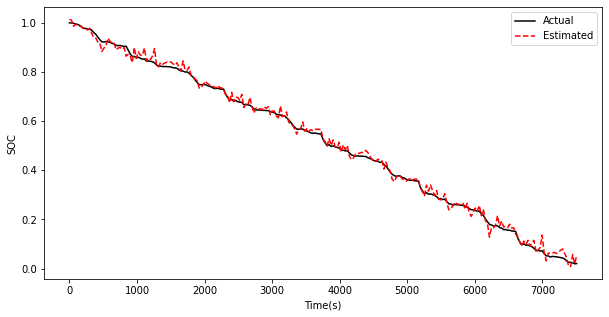

14/14 [==============================] - 2s 134ms/step - loss: 2.1504e-04 - mean_squared_error: 4.3008e-04 - mean_absolute_error: 0.0166 - mean_absolute_percentage_error: 18.7411 - rmse: 0.0207
[0.00021504086907953024, 0.0004300817381590605, 0.016571450978517532, 18.741125106811523, 0.02073841169476509]


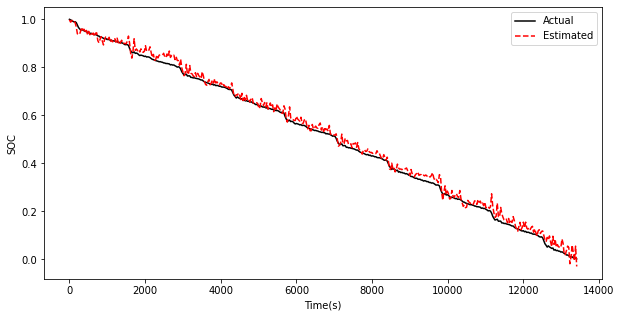

3/3 [==============================] - 0s 179ms/step - loss: 6.0865e-04 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 9.6733 - rmse: 0.0349
[0.0006086487555876374, 0.0012172975111752748, 0.025683309882879257, 9.673340797424316, 0.034889791160821915]


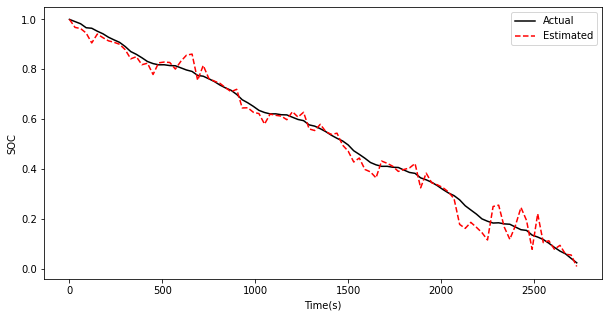

6/6 [==============================] - 1s 151ms/step - loss: 3.4697e-04 - mean_squared_error: 6.9393e-04 - mean_absolute_error: 0.0192 - mean_absolute_percentage_error: 8.9512 - rmse: 0.0263
[0.00034696629154495895, 0.0006939325830899179, 0.01920926943421364, 8.951229095458984, 0.02634260058403015]


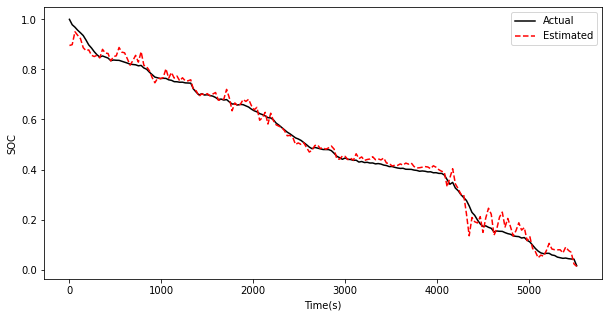

In [89]:
test_x, test_y = get_test_data(
    [
        "0degC/589_LA92",
        "0degC/589_UDDS",
        "0degC/589_US06",
        #'0degC/589_HWFET',
        "0degC/590_Mixed7",
    ]
)
print(model.evaluate(test_x, test_y[:, :, 0]))

show_result("0degC/589_LA92", "0degC_589_LA92")
show_result("0degC/589_UDDS", "0degC_589_UDDS")
show_result("0degC/589_US06", "0degC_589_US06")
show_result("0degC/590_Mixed7", "0degC_590_Mixed7")

## 10deg C

There is a NaN in cycle 10degC/582_LA92, removing row
34/34 [==============================] - 3s 87ms/step - loss: 2.2577e-04 - mean_squared_error: 4.5153e-04 - mean_absolute_error: 0.0161 - mean_absolute_percentage_error: 8.6159 - rmse: 0.0212
[0.00022576525225304067, 0.00045153050450608134, 0.016099615022540092, 8.615928649902344, 0.02124924771487713]
15/15 [==============================] - 2s 138ms/step - loss: 1.4189e-04 - mean_squared_error: 2.8378e-04 - mean_absolute_error: 0.0132 - mean_absolute_percentage_error: 8.4399 - rmse: 0.0168
[0.0001418915780959651, 0.0002837831561919302, 0.013175155967473984, 8.4398832321167, 0.016845865175127983]


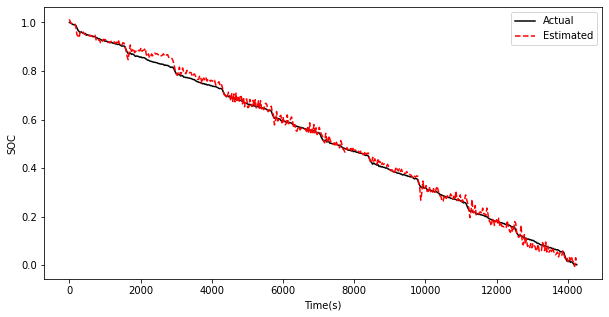

4/4 [==============================] - 1s 136ms/step - loss: 7.1325e-04 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0312 - mean_absolute_percentage_error: 11.0589 - rmse: 0.0378
[0.0007132531027309597, 0.0014265062054619193, 0.031201565638184547, 11.058889389038086, 0.03776911646127701]


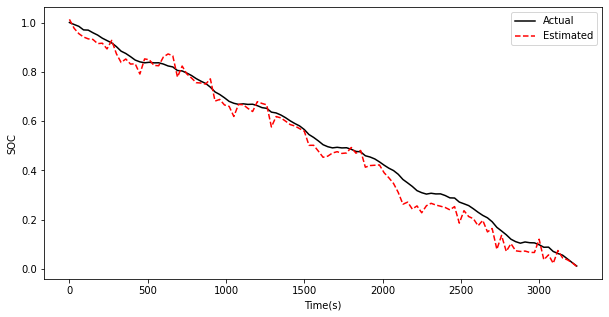

There is a NaN in cycle 10degC/582_LA92, removing row
9/9 [==============================] - 1s 143ms/step - loss: 1.6602e-04 - mean_squared_error: 3.3204e-04 - mean_absolute_error: 0.0146 - mean_absolute_percentage_error: 7.5741 - rmse: 0.0182
[0.0001660187408560887, 0.0003320374817121774, 0.014643718488514423, 7.574120044708252, 0.018221896141767502]


There is a NaN in cycle 10degC/582_LA92, removing row


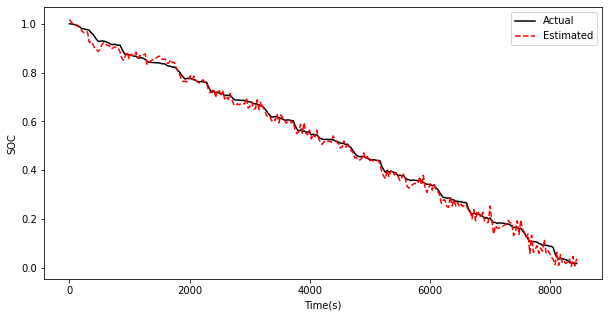

7/7 [==============================] - 1s 140ms/step - loss: 2.4300e-04 - mean_squared_error: 4.8600e-04 - mean_absolute_error: 0.0168 - mean_absolute_percentage_error: 9.1435 - rmse: 0.0220
[0.00024299872166011482, 0.00048599744332022965, 0.016841281205415726, 9.143450736999512, 0.022045349702239037]


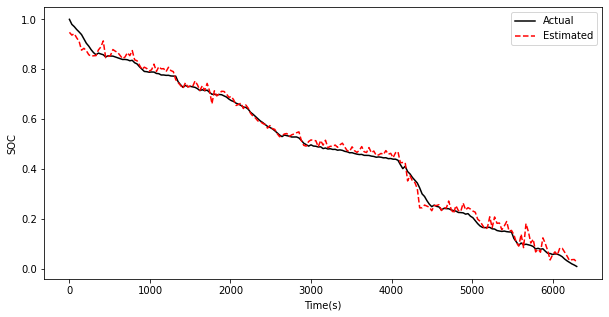

In [90]:
test_x, test_y = get_test_data(
    [
        "10degC/576_UDDS",
        "10degC/567_US06",
        "10degC/582_LA92",
        #'10degC/576_HWFET',
        "10degC/571_Mixed7",
    ]
)
print(model.evaluate(test_x, test_y[:, :, 0]))

show_result("10degC/576_UDDS", "10degC_576_UDDS")
show_result("10degC/567_US06", "10degC_567_US06")
show_result("10degC/582_LA92", "10degC_582_LA92")
# show_result('10degC/576_HWFET', '10degC_576_HWFET')
show_result("10degC/571_Mixed7", "10degC_571_Mixed7")

## 25 deg Celcius

33/33 [==============================] - 3s 97ms/step - loss: 9.7113e-05 - mean_squared_error: 1.9423e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 5.0467 - rmse: 0.0139
[9.711345046525821e-05, 0.00019422690093051642, 0.01048432756215334, 5.046725273132324, 0.01393653079867363]
16/16 [==============================] - 3s 172ms/step - loss: 7.8702e-05 - mean_squared_error: 1.5740e-04 - mean_absolute_error: 0.0096 - mean_absolute_percentage_error: 3.4915 - rmse: 0.0125
[7.870238914620131e-05, 0.00015740477829240263, 0.00961095467209816, 3.4914779663085938, 0.012546106241643429]


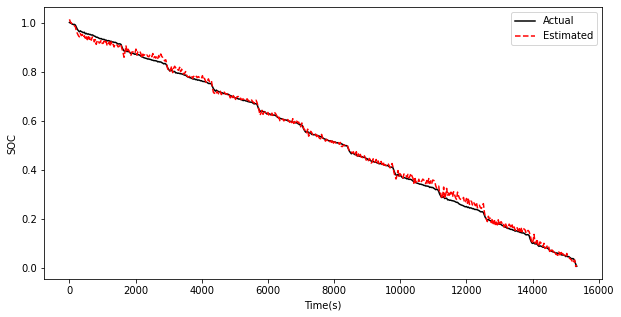

10/10 [==============================] - 1s 142ms/step - loss: 9.3670e-05 - mean_squared_error: 1.8734e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 7.0285 - rmse: 0.0137
[9.366976883029565e-05, 0.0001873395376605913, 0.010286679491400719, 7.028475284576416, 0.013687203638255596]


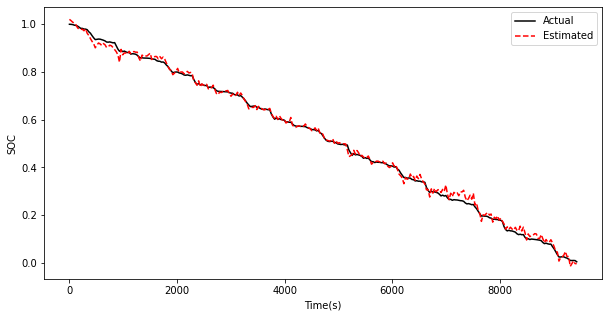

7/7 [==============================] - 1s 141ms/step - loss: 1.4404e-04 - mean_squared_error: 2.8808e-04 - mean_absolute_error: 0.0128 - mean_absolute_percentage_error: 5.8147 - rmse: 0.0170
[0.0001440384949091822, 0.0002880769898183644, 0.012758558616042137, 5.8147406578063965, 0.016972830519080162]


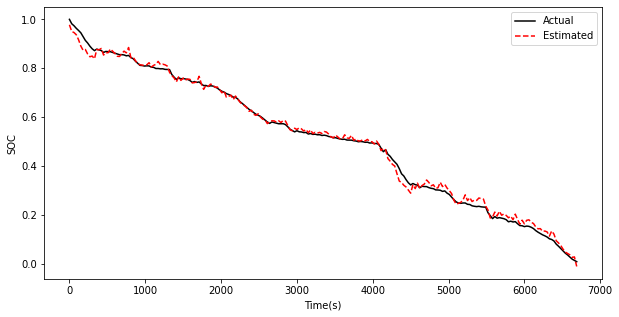

In [91]:
test_x, test_y = get_test_data(
    ["25degC/551_LA92", "25degC/551_UDDS", "25degC/552_Mixed7"]
)

print(model.evaluate(test_x, test_y[:, :, 0]))

show_result("25degC/551_UDDS", "25degC_551_UDDS")
show_result("25degC/551_LA92", "25degC_551_LA92")
show_result("25degC/552_Mixed7", "25degC_552_Mixed7")